## 1. Import Modules and Data

This script processes a corpus to prepare data for BERT-style training. The dataset is implemented in the **BERTDataset** class, which reads and tokenizes text, generates masked tokens for training, and creates segment labels. The vocabulary is built using the WordVocab class, which counts word frequencies and assigns token indices.

The corpus is first loaded from a text file, where each line consists of two tab-separated sentences. Here I load the first parquet file of datasets **Bookcorpus** and **Wikipedia(20231101.en)** to create a txt file named corpus.txt.

The dataset supports both memory-based and file-streaming modes. The **random_word** function randomly replaces words with mask tokens for masked language modeling(MLM), while **random_sent** generates paired sentences for next-sentence prediction(NSP).
The vocabulary is built using a word counter and saved to disk for reuse. In **build()**, the text is preprocessed, and a vocabulary is created based on word frequency thresholds. Finally, the vocabulary is saved for training.

In [ ]:
import nltk
nltk.download("punkt")

In [1]:
import data
from torch.utils.data import DataLoader
import config
# load bookcorpus and english wikipedia
data.load_bookcorpus_wikipedia(0.1, 1/41)

data.build()
print("loading train dataset done")

Vocab already exists! If you want to rebuild it, please delete the existing vocab file.
loading train dataset done


In [2]:
from data import WordVocab, BERTDataset
print("Loading Vocab", config.vocab_path)
vocab = WordVocab.load_vocab(config.vocab_path)
print("Vocab Size: ", len(vocab))

print("Loading Train Dataset", config.train_dataset)
train_dataset = BERTDataset(config.train_dataset, vocab, seq_len=config.sequence_length,
                            corpus_lines=config.corpus_lines, on_memory=config.on_memory, loading_ratio=0.000001)
print("Train Dataset Size: ", len(train_dataset))

print("Loading Test Dataset", config.test_dataset)
test_dataset = BERTDataset(config.test_dataset, vocab, seq_len=config.sequence_length, on_memory=config.on_memory, loading_ratio=0.05) \
    if config.test_dataset is not None else None

print("Creating Dataloader")
train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers) \
    if test_dataset is not None else None

Loading Vocab /root/autodl-tmp/bert/dataset/vocab
Vocab Size:  30522
Loading Train Dataset /root/autodl-tmp/bert/dataset/corpus.txt
num_load_lines: 11


Loading Dataset: 100%|██████████| 11/11 [00:00<00:00, 82241.25it/s]

length of self.lines: 11
Train Dataset Size:  11
Loading Test Dataset None
Creating Dataloader


## 2. Build Model
Build the model

In [3]:
from modules.bert import BERT
print("Building BERT model")
bert = BERT(
    len(vocab), 
    hidden=config.hidden_size, 
    n_layers=config.num_layers, 
    attn_heads=config.attention_heads
)
print(bert)

Building BERT model
BERT(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(30522, 768, padding_idx=0)
    (position): PositionalEmbedding(512, 768)
    (segment): SegmentEmbedding(2, 768, padding_idx=0)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (self_attn): MultiheadAttention(
        (attention): ScaledDotProductAttention()
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_concat): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm()
      (ffn): PositionwiseFeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fa

## 3. Train Model
Here I define a BERTTrainer class for pretraing settings.

In [6]:
import torch
import torch.nn as nn
import tqdm
from torch.optim import Adam
from modules.bertLM import BERTLM
from modules.bert import BERT, ScheduledOptim


class BERTTrainer:
    """
    BERTTrainer make the pretrained BERT model with two LM training method.

        1. Masked Language Model : 3.3.1 Task #1: Masked LM
        2. Next Sentence prediction : 3.3.2 Task #2: Next Sentence Prediction

    please check the details on README.md with simple example.

    """

    def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, test_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01, warmup_steps=10000, total_steps=1000000,
                 with_cuda: bool = True, cuda_devices=None, log_freq: int = 10):
        """
        :param bert: BERT model which you want to train
        :param vocab_size: total word vocab size
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: learning rate of optimizer
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param with_cuda: traning with cuda
        :param log_freq: logging frequency of the batch iteration
        """

        # Setup cuda device for BERT training, argument -c, --cuda should be true
        cuda_condition = torch.cuda.is_available() and with_cuda
        self.device = torch.device("cuda:0" if cuda_condition else "cpu")

        # This BERT model will be saved every epoch
        self.bert = bert
        # Initialize the BERT Language Model, with BERT model
        self.model = BERTLM(bert, vocab_size).to(self.device)

        # Distributed GPU training if CUDA can detect more than 1 GPU
        if with_cuda and torch.cuda.device_count() > 1:
            print("Using %d GPUS for BERT" % torch.cuda.device_count())
            self.model = nn.DataParallel(self.model, device_ids=cuda_devices)

        # Setting the train and test data loader
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(self.optim, n_warmup_steps=warmup_steps, total_steps=total_steps)

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = nn.NLLLoss(ignore_index=0)

        self.log_freq = log_freq

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        """
        loop over the data_loader for training or testing
        if on train status, backward operation is activated
        and also auto save the model every peoch

        :param epoch: current epoch index
        :param data_loader: torch.utils.data.DataLoader for iteration
        :param train: boolean value of is train or test
        :return: None
        """
        str_code = "train" if train else "test"

        # Setting the tqdm progress bar
        data_iter = tqdm.tqdm(enumerate(data_loader),
                              desc="EP_%s:%d" % (str_code, epoch),
                              total=len(data_loader),
                              bar_format="{l_bar}{r_bar}")

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))

        print("EP%d_%s, avg_loss=" % (epoch, str_code), avg_loss / len(data_iter), "total_acc=",
              total_correct * 100.0 / total_element)

    def save(self, epoch, file_path):
        """
        Saving the current BERT model on file_path

        :param epoch: current epoch number
        :param file_path: model output path which gonna be file_path+"ep%d" % epoch
        :return: final_output_path
        """
        output_path = str(file_path) + "_ep%d.pth" % epoch
        torch.save(self.bert.cpu(), output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)
        return output_path

    
trainer = BERTTrainer(
    bert, len(vocab), 
    train_dataloader=train_data_loader, 
    test_dataloader=test_data_loader,       
    lr=config.learning_rate,     
    betas=(config.adam_beta1, config.adam_beta2),
    weight_decay=config.adam_weight_decay,
    warmup_steps=config.warmup_steps,
    total_steps = config.total_steps,
    with_cuda=config.with_cuda, 
    cuda_devices=config.cuda_devices, 
    log_freq=config.log_freq
)

Total Parameters: 132363068


### 3.1 Optimizer and Scheduler
ScheduledOptim class is a wrapper for an optimizer that implements a learning rate scheduling strategy inspired by the Transformer paper (Attention Is All You Need). It adjusts the learning rate using a warm-up and decay mechanism to stabilize training. 

Original paper shows that they use Adam with learning rate of 1e-4, β1 = 0.9, β2 = 0.999, L2 weight decay of 0.01, learning rate warmup over the first 10,000 steps, and linear decay of the learning rate in the pretraining

Check modules/optim_schedule.py for deeper understanding.

The learing rate schedule is shown as below.

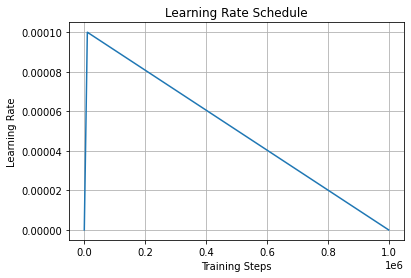

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from modules.bert import ScheduledOptim
import config

#random create one model
test_model = torch.nn.Linear(10, 1)


optimizer = Adam(test_model.parameters(), lr=config.learning_rate, betas=(config.adam_beta1, config.adam_beta2), weight_decay=config.adam_weight_decay)

lr_values = []

scheduler = ScheduledOptim(optimizer,config.warmup_steps,config.total_steps)

for _ in range(config.total_steps):
    
    # update lr
    scheduler.step_and_update_lr()
    lr = optimizer.param_groups[0]['lr']
    lr_values.append(lr)
    

# 绘制学习率曲线
plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### 3.2 Train loop
Simple test of pretraining process.

In [8]:
print("Training Start")
for epoch in range(config.epochs):
    trainer.train(epoch)
    if epoch % config.log_freq == 0:
        trainer.save(epoch, config.trained_path)
    if test_data_loader is not None:
        trainer.test(epoch)

Training Start


EP_train:0: 100%|| 1/1 [00:00<00:00,  1.90it/s]


{'epoch': 0, 'iter': 0, 'avg_loss': 11.230925559997559, 'avg_acc': 72.72727272727273, 'loss': 11.230925559997559}
EP0_train, avg_loss= 11.230925559997559 total_acc= 72.72727272727273
EP:0 Model Saved on: /root/autodl-tmp/bert/checkpoints/bert_self_trained_ep0.pth


EP_train:1: 100%|| 1/1 [00:00<00:00,  2.02it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 11.146394729614258, 'avg_acc': 63.63636363636363, 'loss': 11.146394729614258}
EP1_train, avg_loss= 11.146394729614258 total_acc= 63.63636363636363
